In [1]:
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
#from helper.utils import *
from ner_crf import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn_crfsuite import metrics

In [2]:
ner = NamedEntityRecognition()

In [3]:
#merged_data = read_tsv('../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../dataset/train.tsv')
val_data = read_tsv('../dataset/val.tsv')
test_data = read_tsv('../dataset/test.tsv')

In [4]:
train_data = to_token_tag_list(train_data)
val_data = to_token_tag_list(val_data)
test_data = to_token_tag_list(test_data)

In [5]:
def get_features(data):
	X = [ner.sent2features(s) for s in data]
	y = [ner.sent2tags(s) for s in data]

	return X, y

In [6]:
X_train, y_train = get_features(train_data)
X_val, y_val = get_features(val_data)
X_test, y_test = get_features(test_data)

In [7]:
print(f"Train set: {len(X_train)} sentences")
print(f"Val set: {len(X_val)} sentences")
print(f"Test set: {len(X_test)} sentences")

Train set: 4556 sentences
Val set: 1139 sentences
Test set: 2805 sentences


### CRF Training

In [8]:
model = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	max_iterations=100,
	all_possible_transitions=True,
	c1=0.1,  # Coefficient for Lasso (L1) regularization for
    c2=0.1,  # Coefficient for Ridge (L2) regularization
)

In [9]:
# train CRF
%time
model.fit(X=X_train, y=y_train, X_dev=X_val, y_dev=y_val)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [10]:
y_pred = model.predict(X_test)

In [11]:
# save model
model_name = 'crf_model_split.pkl'
root_path = 'model/'
joined_path = os.path.join(root_path, model_name)
pickle.dump(model, open(joined_path, 'wb'))


 Evaluation on the test data
Confusion Matrix
              precision    recall  f1-score   support

           O     0.9972    0.9984    0.9978     56762
   I-PURPOSE     0.9403    0.9831    0.9612       946
  I-HERITAGE     0.9484    0.9905    0.9690       631
   I-NATURAL     0.9525    0.9742    0.9632       658
   B-PURPOSE     0.9888    0.9060    0.9456       585
  B-HERITAGE     0.9823    0.8963    0.9373       434
   B-NATURAL     0.9799    0.8689    0.9211       618

    accuracy                         0.9949     60634
   macro avg     0.9699    0.9453    0.9565     60634
weighted avg     0.9950    0.9949    0.9949     60634



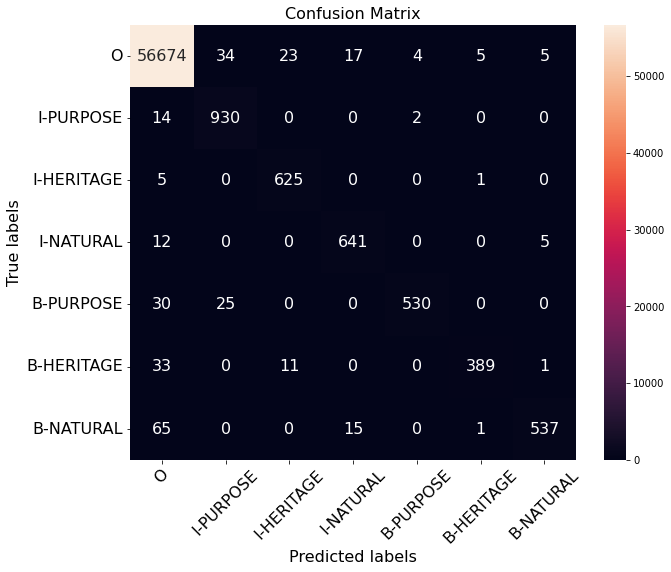

In [12]:
print('\n Evaluation on the test data')
ner.show_confusion_matrix(y_test, y_pred)

# increase font of x and y axis

In [13]:
print("\nTop likely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common()[-20:])

# check the state features
print("\nTop positive:")
ner.print_state_features(Counter(model.state_features_).most_common(20))
print("\nTop negative:")
ner.print_state_features(Counter(model.state_features_).most_common()[-20:])


Top likely transitions:
B-HERITAGE -> I-HERITAGE 2.04253
O          -> O          1.91970
B-PURPOSE  -> I-PURPOSE  1.86540
B-NATURAL  -> I-NATURAL  1.74999
I-NATURAL  -> I-NATURAL  1.72060
O          -> B-PURPOSE  1.53716
O          -> B-NATURAL  1.53592
I-PURPOSE  -> I-PURPOSE  1.45606
I-HERITAGE -> I-HERITAGE 1.23722
O          -> B-HERITAGE 1.16357
I-NATURAL  -> O          0.44050
I-HERITAGE -> O          0.33907
I-PURPOSE  -> O          0.22500
B-NATURAL  -> O          -0.22007
B-HERITAGE -> O          -0.22620
B-PURPOSE  -> O          -0.29955
I-NATURAL  -> B-PURPOSE  -0.38554
I-HERITAGE -> B-PURPOSE  -0.47214
I-HERITAGE -> B-HERITAGE -0.64868
O          -> I-NATURAL  -0.72380

Top unlikely transitions:
B-PURPOSE  -> B-HERITAGE -1.16689
B-NATURAL  -> B-HERITAGE -1.17203
I-NATURAL  -> I-HERITAGE -1.27325
B-PURPOSE  -> I-HERITAGE -1.30504
I-HERITAGE -> I-NATURAL  -1.36631
B-HERITAGE -> B-PURPOSE  -1.39398
B-PURPOSE  -> B-PURPOSE  -1.50264
B-PURPOSE  -> I-NATURAL  -1.54733
O        

In [14]:
import eli5

eli5.show_weights(model,horizontal_layout=False, show=['transition_features'])

From \ To,O,B-HERITAGE,I-HERITAGE,B-NATURAL,I-NATURAL,B-PURPOSE,I-PURPOSE
O,1.92,1.164,-2.94,1.536,-0.724,1.537,-1.565
B-HERITAGE,-0.226,-2.201,2.043,-1.912,-1.714,-1.394,-1.971
I-HERITAGE,0.339,-0.649,1.237,-0.798,-1.366,-0.472,-2.18
B-NATURAL,-0.22,-1.172,-1.093,-0.784,1.75,-1.611,-2.092
I-NATURAL,0.441,-0.922,-1.273,-0.924,1.721,-0.386,-2.092
B-PURPOSE,-0.3,-1.167,-1.305,-1.123,-1.547,-1.503,1.865
I-PURPOSE,0.225,-1.084,-1.769,-0.887,-1.645,-0.938,1.456


In [15]:
eli5.show_weights(model, targets=['O','B-HERITAGE','I-HERITAGE'])

In [16]:
eli5.show_weights(model, targets=['B-NATURAL','I-NATURAL','B-PURPOSE','I-PURPOSE'])